Notebook for analyzing the results of a hyperparameter run.

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle
import numpy as np
from toy_data import *
from targprop import *
from targprop_aunc import run_tprop_aunc
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
import pandas as pd

# process the hyperparameter run

In [111]:
RUN = './saves/mnist_aunc_Jan10b/'

In [112]:
files = [i for i in os.listdir(RUN) if i!='.DS_Store']
total_sims = len(files)

# the pickle file is a list of 
# -params
# -error vs training step
# -test error
# -last-layer activations

# start with the first file
data = pickle.load(open(RUN+files[0], 'rb'))
params = data[0]
loss_test = data[2]
loss = data[1][:,:,-1]

# go through the remaining files
for i,j in params.items():
  params[i] = [j]
for i in range(1,len(files)):
  data = pickle.load(open(RUN+files[i], 'rb'))
  for i,j in data[0].items():
    params[i].append(j)
  loss_test = np.dstack((loss_test, data[2]))
  loss = np.dstack((loss, data[1][:,:,-1]))

For vestigial reasons, `loss_test` and `activations` are of shape `(3,3,total_sims)`. The first two axes correspond to `params['training_algs']` and `params['err_algs']` respectively. This is so we can compare multiple training algorithms and error propagation algorithms for a given choice of hyperparameters. This was later modified to just analyze one at a time.

In [113]:
# get just the nonzero losses -- the np array was initialized to 0
loss_test = np.max(loss_test, axis=(0,1))
loss = np.max(loss, axis=(0,1))

In [114]:
# panda panda panda
df = pd.DataFrame(params)
df = df.join(pd.DataFrame({'MSE': loss_test}))

In [115]:
mnist = mnist_data_test()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# visualize the reconstruction
Find the best choice of hyperparameters for a given `error_alg`, `training_alg`, and `h_dim`

In [127]:
print 'error algs: ', np.unique(params['err_algs'])
print 'training algs: ', np.unique(params['training_algs'])
print 'hidden dims: ', np.unique(params['h_dim'])

error algs:  [0 1 2]
training algs:  [0]
hidden dims:  [2 3]


In [128]:
# which to visualize
err_alg = 0
training_alg = 0
h_dim = 2

In [129]:
idx1 = np.array([k==err_alg for k in params['err_algs']])
idx2 = np.array([k==training_alg for k in params['training_algs']])
idx3 = np.array([k==h_dim for k in params['h_dim']])
idx = np.array([a and b and c for a,b,c, in zip(idx1,idx2,idx3)])
best = np.where(idx == True)[0][np.nanargmin(loss_test[idx])]
print best

859


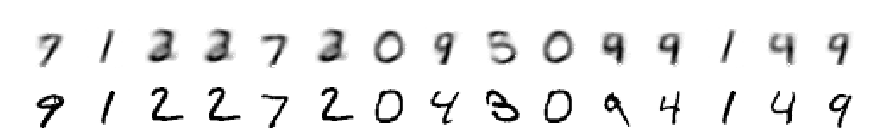

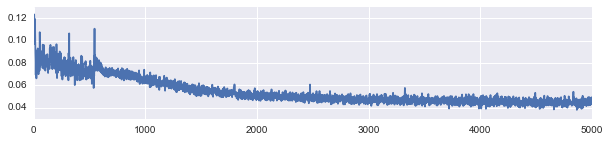

In [130]:
i = best 
data = pickle.load(open(RUN+files[i], 'rb'))
actvs = data[3][params['err_algs'][i], params['training_algs'][i]]

n = 15
f, ax = plt.subplots(2, n, figsize=(n,2))

for col in range(n):
  example = np.random.randint(actvs.shape[0])
  ax[1, col].matshow(mnist.inputs[example].reshape((28,28)))
  ax[0, col].matshow(actvs[example].reshape((28,28)))
  ax[1, col].axis('off')
  ax[0, col].axis('off')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(data[1][params['err_algs'][i], params['training_algs'][i]])
plt.show()

In [135]:
#df_ = df[np.abs(df.MSE - df.MSE.mean()) <= (3*df.MSE.std())]

err_alg = 2
training_alg = 0
h_dim = 2

idx1 = np.array([k==err_alg for k in params['err_algs']])
idx2 = np.array([k==training_alg for k in params['training_algs']])
idx3 = np.array([k==h_dim for k in params['h_dim']])
idx = np.array([a and b and c for a,b,c, in zip(idx1,idx2,idx3)])
#best = np.where(idx == True)[0][np.nanargmin(out_t[idx])]
#print best

#training_alg = 0
#err_alg = 0
#h_dim = 
#idx = [k==training_alg and j==err_alg for k,j in zip(params['training_algs'], params['err_algs'])] 
#idx = np.array(idx)
idx = np.logical_and(idx, df.MSE < 0.5)
df_ = df[idx]
df_ = df_.join(df_['nonlinearity'] == 'relu', rsuffix='_bool')
print df.shape
print df_.shape

(1000, 12)
(90, 13)


In [137]:
df_.columns

Index([u'alpha', u'alpha_inv', u'batch_size', u'beta_W', u'beta_b', u'beta_t',
       u'err_algs', u'h_dim', u'layers', u'nonlinearity', u'training_algs',
       u'MSE', u'nonlinearity_bool'],
      dtype='object')

In [138]:
cols = [u'alpha', u'alpha_inv', u'batch_size', u'beta_W', u'beta_b', u'beta_t',
       u'err_algs', u'layers', u'training_algs', u'nonlinearity_bool']
rows = [u'MSE', u'MSE']

logx = [u'alpha', u'beta_W', u'beta_b', u'beta_t']

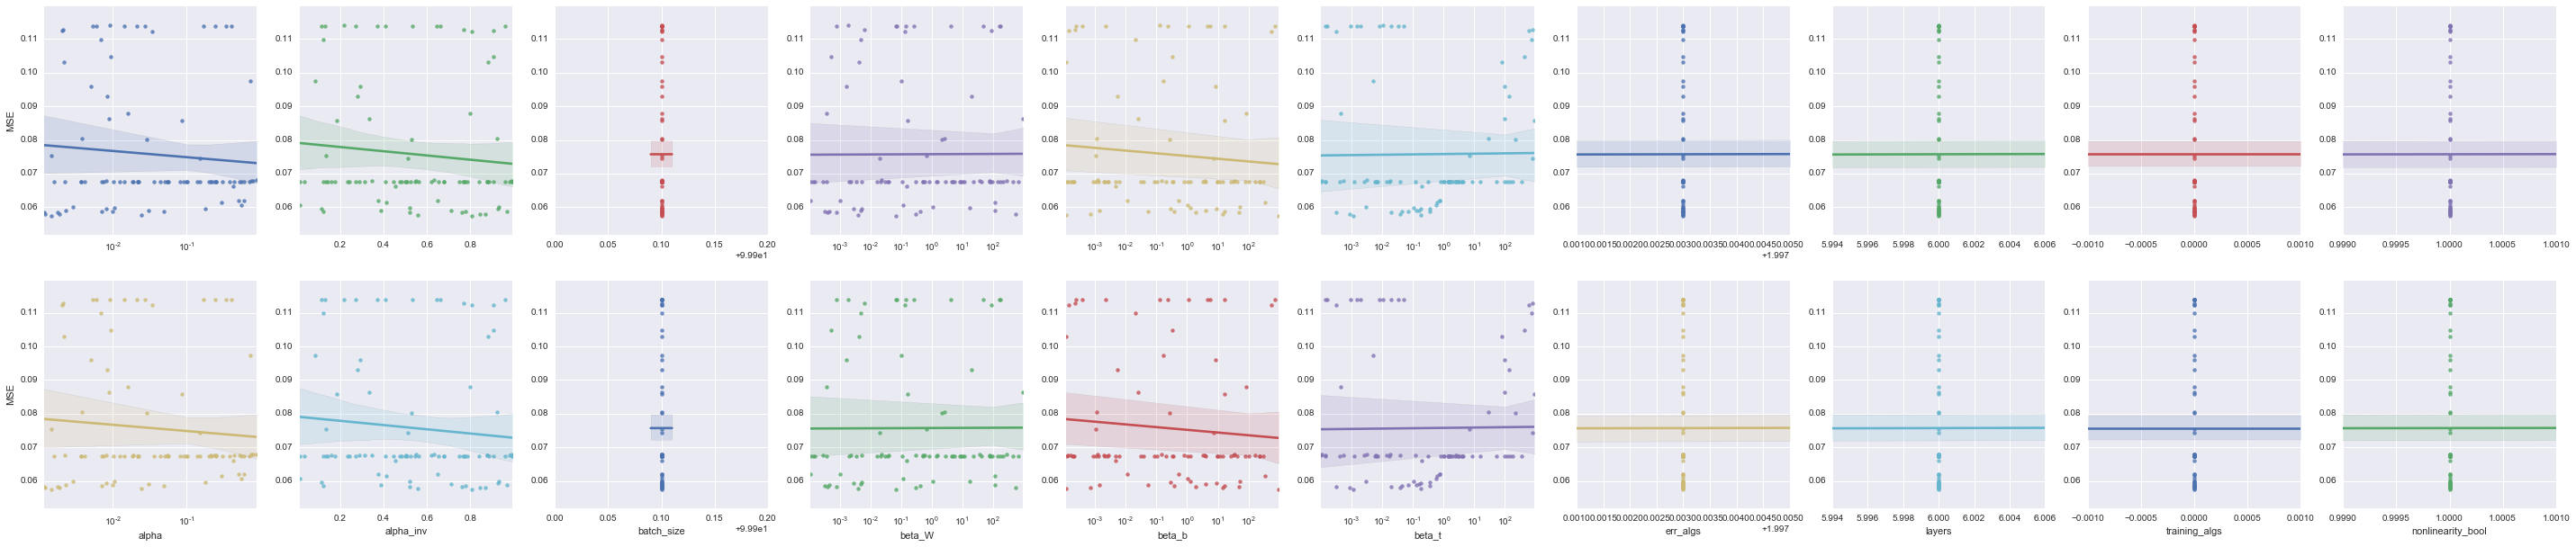

In [139]:
num_cols = len(cols)
num_rows = len(rows)

f, ax = plt.subplots(num_rows, num_cols, figsize=(50,10), sharey=False, sharex=False)

for ir, row in enumerate(rows):
  for ic, col,  in enumerate(cols):
    logx_bool = col in logx
    if logx_bool:
      ax[ir, ic].set_xscale('log', basex=10)
    sns.regplot(col, row, df_, logx=logx_bool, ax=ax[ir, ic], truncate=False)
    if ir < num_rows-1:
      ax[ir, ic].xaxis.label.set_visible(False)
    if ic > 0:
      ax[ir, ic].yaxis.label.set_visible(False)
      
    d_range = df_[row].max() - df_[row].min()
    ax[ir, ic].set_ylim([df_[row].min()-0.1*d_range, df_[row].max()+0.1*d_range])
    ax[ir, ic].set_xlim([df_[col].min(), df_[col].max()])

    # plot ref lines
    
    # get right xlim/ylim
      
plt.show()

# Run one instance

In [ ]:
# normal version
L, acc, L_t, acc_t, x_1, x_2, x_3 =run_tprop(batch_size=100,
                                              t_steps=50,
                                              SGD=True,
                                              layers=4,
                                              h_dim=400,
                                              nonlinearity='relu',
                                              alpha=0.03,
                                              alpha_t=1,
                                              alpha_inv=0.3,
                                              beta_t=1,
                                              beta_W=1,
                                              beta_b=1,
                                              pinv_rcond=1e-3,
                                              nonlin_thresh=1e-2,
                                              dataset='mnist',
                                              preprocess=False)
print acc_t

In [ ]:
np.random.choice([0,1,2], size=1)

In [ ]:
# aunc version
L, L_t, x_3 = run_tprop_aunc(batch_size=1000,
                            t_steps=200,
                            SGD=True,
                            layers=6,
                            nonlinearity='tanh',
                            alpha=0.059823506906078044,
                            alpha_t=1,
                            alpha_inv=0.60915382572973897,
                            beta_t=0.36259831882905597,
                            beta_W=0.17561771047604827,
                            beta_b=0.28050966890030765,
                            pinv_rcond=1e-3,
                            nonlin_thresh=1e-2,
                            dataset='mnist',
                            preprocess=False)

In [ ]:
plt.figure(figsize=(10,5))
with sns.color_palette(n_colors=3):
  plt.plot(L[0,0,:], label='bprop | gd')
  plt.plot(L[1,0,:], label='tprop | gd')
  plt.plot(L[2,0,:], label='reg tprop | gd')

  plt.plot(L[0,1,:], '--', label='bprop | pinv')
  plt.plot(L[1,1,:], '--', label='tprop | pinv')
  plt.plot(L[2,1,:], '--', label='reg tprop | pinv')
  
  plt.plot(L[0,2,:], alpha=0.5, label='bprop | reg inv')
  plt.plot(L[1,2,:], alpha=0.5, label='tprop | reg inv')
  plt.plot(L[2,2,:], alpha=0.5, label='reg tprop | reg inv')

plt.ylim([-.01, 0.55])
plt.xlim([-10, 231])
plt.legend()
plt.show()

In [ ]:
example = np.random.randint(x_3[0,0,0].shape[0])
plt.figure()
plt.matshow(x_3[err_alg,upd_alg,0][example].reshape((28,28)))

fig, ax = plt.subplots(3, 3, figsize=(15,15))
ax[0,0].matshow(x_3[0,0,-1][example].reshape((28,28)))
ax[0,1].matshow(x_3[0,1,-1][example].reshape((28,28)))
ax[0,2].matshow(x_3[0,2,-1][example].reshape((28,28)))

ax[1,0].matshow(x_3[1,0,-1][example].reshape((28,28)))
ax[1,1].matshow(x_3[1,1,-1][example].reshape((28,28)))
ax[1,2].matshow(x_3[1,2,-1][example].reshape((28,28)))

ax[2,0].matshow(x_3[2,0,-1][example].reshape((28,28)))
ax[2,1].matshow(x_3[2,1,-1][example].reshape((28,28)))
ax[2,2].matshow(x_3[2,2,-1][example].reshape((28,28)))


In [ ]:
L, acc, L_t, acc_t = run_tprop(batch_size = 100,
                               t_steps = 200,
                               layers = 4,
                               alpha = 0.03,
                               alpha_t = 0.05,
                               SGD = True,
                               pinv_rcond=1e-2,
                               nonlin_thresh=1e-2,
                               beta_1=1e0,
                               beta_2=1e0,
                               gamma=0.1,
                               nonlinearity='tanh')
print acc_t

In [ ]:
plt.figure(figsize=(10,5))
with sns.color_palette(n_colors=3):
  plt.plot(acc[0,0,:], label='bprop | gd')
  plt.plot(acc[1,0,:], label='tprop | gd')
  plt.plot(acc[2,0,:], label='reg tprop | gd')

  plt.plot(acc[0,1,:], '--', label='bprop | pinv')
  plt.plot(acc[1,1,:], '--', label='tprop | pinv')
  plt.plot(acc[2,1,:], '--', label='reg tprop | pinv')
  
  plt.plot(acc[0,2,:], alpha=0.5, label='bprop | reg inv')
  plt.plot(acc[1,2,:], alpha=0.5, label='tprop | reg inv')
  plt.plot(acc[2,2,:], alpha=0.5, label='reg tprop | reg inv')

plt.ylim([-.1, 1.1])
plt.xlim([-1, 201])
plt.legend()
plt.show()